In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=144 #288個一組 (24小時一組)
currency = ["SEK","CHF","CAD","GBP","JPY","EUR","AUD","SGD","HKD","NZD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136084,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 40
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2,typeq):
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    outcome[6]=(data2_sum[6])
    outcome[7]=(data2_sum[7])
    outcome[8]=(data2_sum[8])
    outcome[9]=(data2_sum[9])    
    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    outcome[6]=data2_std[6]     
    outcome[7]=data2_std[7]
    outcome[8]=data2_std[8]     
    outcome[9]=data2_std[9] 
    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)

In [7]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=6))(model)
        model = BatchNormalization()(model)
        return model
    return conv


def f_theta():
    def f(model):
        model = Dense(64)(model)
        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Activation('relu')(model)
#        model = Dense(64)(model)
#        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Dropout(0.5)(model)
        model = Activation('relu')(model)
        return model
    return f

In [12]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==60):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==60):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])


    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(148335, 1)
finish dataread
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=23.3 GiB, count=2, average=11.6 GiB
[Training model......]
Train on 1649070 samples, validate on 494640 samples
Epoch 1/20
1649070/1649070 [==============================] - 29s 18us/step - loss: 0.6871 - acc: 0.5629 - val_loss: 0.6763 - val_acc: 0.6090
Epoch 2/20
1649070/1649070 [==============================] - 23s 14us/step - loss: 0.6533 - acc: 0.6183 - val_loss: 0.6357 - val_acc: 0.6168
Epoch 3/20
1649070/1649070 [==============================] - 22s 13us/step - loss: 0.6207 - acc: 0.6337 - val_loss: 0.6207 - val_acc: 0.6207
Epoch 4/20
1649070/1649070 [==============================] - 23s 14us/step - loss: 0.6068 - acc: 0.6362 - val_loss: 0.6153 - val_acc: 0.6212
Epoch 5/20
1649070/1649070 [==============================] - 22s 13us/step - loss: 0.6004 - acc: 0.6376 - val_loss: 0.6134 - val_acc: 0.6263
Epoch 6/20
1649070/1649070 [===================

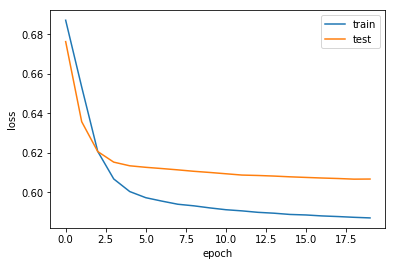

acc:
0.6405337553639556
val_acc:
0.6199640143848866


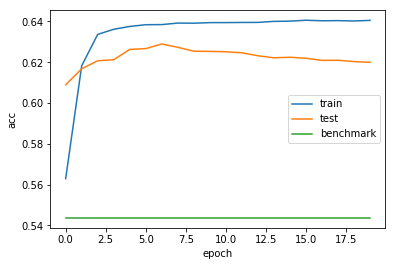

(148335, 1)
finish dataread
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=23.6 GiB, count=57, average=424 MiB
[Training model......]
Train on 1606950 samples, validate on 564930 samples
Epoch 1/20
1606950/1606950 [==============================] - 23s 14us/step - loss: 0.6886 - acc: 0.5619 - val_loss: 0.6788 - val_acc: 0.6125
Epoch 2/20
1606950/1606950 [==============================] - 22s 13us/step - loss: 0.6535 - acc: 0.6262 - val_loss: 0.6347 - val_acc: 0.6178
Epoch 3/20
1606950/1606950 [==============================] - 22s 13us/step - loss: 0.6177 - acc: 0.6343 - val_loss: 0.6178 - val_acc: 0.6256
Epoch 4/20
1606950/1606950 [==============================] - 22s 13us/step - loss: 0.6049 - acc: 0.6361 - val_loss: 0.6130 - val_acc: 0.6273
Epoch 5/20
1606950/1606950 [==============================] - 22s 13us/step - loss: 0.6002 - acc: 0.6371 - val_loss: 0.6114 - val_acc: 0.6270
Epoch 6/20
1606950/1606950 [===================

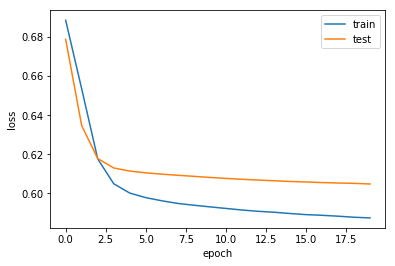

acc:
0.6403746227166304
val_acc:
0.6260244633428813


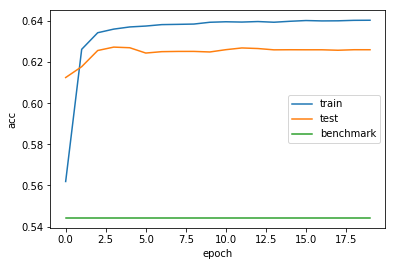

(148335, 1)
finish dataread
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=24.2 GiB, count=59, average=419 MiB
[Training model......]
Train on 1681020 samples, validate on 544320 samples
Epoch 1/20
1681020/1681020 [==============================] - 20s 12us/step - loss: 0.6883 - acc: 0.5628 - val_loss: 0.6779 - val_acc: 0.6004
Epoch 2/20
1681020/1681020 [==============================] - 19s 11us/step - loss: 0.6525 - acc: 0.6235 - val_loss: 0.6353 - val_acc: 0.6163
Epoch 3/20
1681020/1681020 [==============================] - 19s 11us/step - loss: 0.6187 - acc: 0.6329 - val_loss: 0.6171 - val_acc: 0.6228
Epoch 4/20
1681020/1681020 [==============================] - 19s 11us/step - loss: 0.6050 - acc: 0.6355 - val_loss: 0.6111 - val_acc: 0.6257
Epoch 5/20
1681020/1681020 [==============================] - 19s 11us/step - loss: 0.6000 - acc: 0.6364 - val_loss: 0.6092 - val_acc: 0.6270
Epoch 6/20
1681020/1681020 [===================

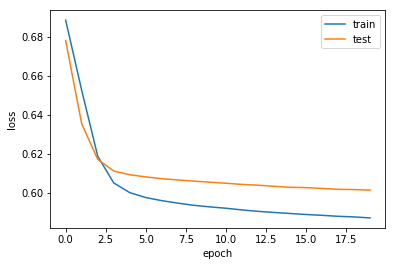

acc:
0.6405902369053771
val_acc:
0.62472442665358


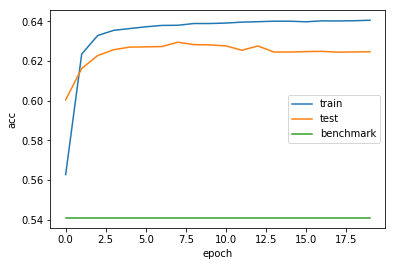

(148335, 1)
finish dataread
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=23.6 GiB, count=61, average=396 MiB
[Training model......]
Train on 1655730 samples, validate on 518400 samples
Epoch 1/20
1655730/1655730 [==============================] - 19s 12us/step - loss: 0.6871 - acc: 0.5690 - val_loss: 0.6773 - val_acc: 0.6124
Epoch 2/20
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.6534 - acc: 0.6277 - val_loss: 0.6376 - val_acc: 0.6202
Epoch 3/20
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.6194 - acc: 0.6350 - val_loss: 0.6178 - val_acc: 0.6207
Epoch 4/20
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.6052 - acc: 0.6368 - val_loss: 0.6129 - val_acc: 0.6231
Epoch 5/20
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.6005 - acc: 0.6370 - val_loss: 0.6116 - val_acc: 0.6235
Epoch 6/20
1655730/1655730 [===================

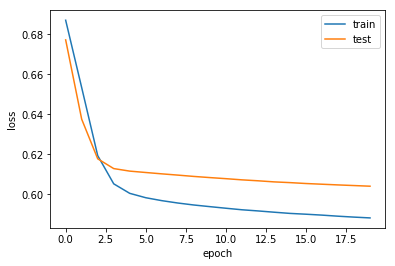

acc:
0.6405808918198466
val_acc:
0.6239178241918116


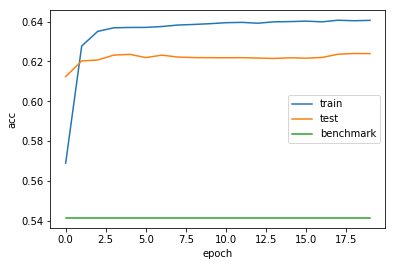

(148335, 1)
finish dataread
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=24.4 GiB, count=62, average=403 MiB
[Training model......]
Train on 1679490 samples, validate on 570240 samples
Epoch 1/20
1679490/1679490 [==============================] - 21s 12us/step - loss: 0.6869 - acc: 0.5676 - val_loss: 0.6731 - val_acc: 0.6117
Epoch 2/20
1679490/1679490 [==============================] - 18s 11us/step - loss: 0.6488 - acc: 0.6302 - val_loss: 0.6339 - val_acc: 0.6192
Epoch 3/20
1679490/1679490 [==============================] - 18s 11us/step - loss: 0.6173 - acc: 0.6371 - val_loss: 0.6160 - val_acc: 0.6211
Epoch 4/20
1679490/1679490 [==============================] - 18s 11us/step - loss: 0.6042 - acc: 0.6379 - val_loss: 0.6099 - val_acc: 0.6268
Epoch 5/20
1679490/1679490 [==============================] - 18s 11us/step - loss: 0.5994 - acc: 0.6373 - val_loss: 0.6082 - val_acc: 0.6267
Epoch 6/20
1679490/1679490 [===================

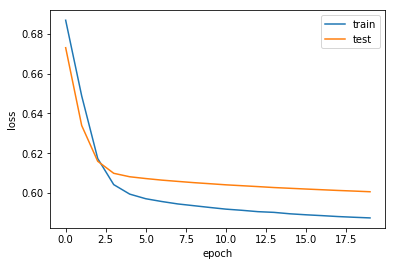

acc:
0.6410344807046715
val_acc:
0.6254033389048678


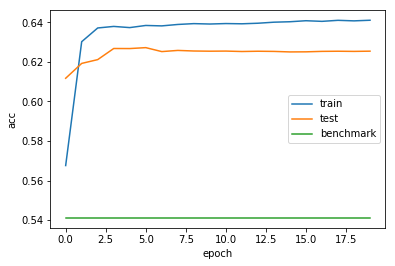

In [13]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SEK_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sek5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sek5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SGD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sgd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sgd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/NZD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    nzd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        nzd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=sek5months[p:p+l]
        Train_data[p,1,:]=chf5months[p:p+l]
        Train_data[p,2,:]=cad5months[p:p+l]
        Train_data[p,3,:]=gbp5months[p:p+l]
        Train_data[p,4,:]=jpy5months[p:p+l]
        Train_data[p,5,:]=eur5months[p:p+l]
        Train_data[p,6,:]=aud5months[p:p+l]  
        Train_data[p,7,:]=sgd5months[p:p+l]
        Train_data[p,8,:]=hkd5months[p:p+l]
        Train_data[p,9,:]=nzd5months[p:p+l] 
    MLP_unit=64
    baseline_scene = Input((l,currencynum))
    baseline_question = Input((22,))
    baseline_conv = ConvolutionNetworks(20,5)(baseline_scene)
    baseline_conv = Flatten()(baseline_conv)
    baseline_conv = Concatenate()([baseline_conv, baseline_question])
    baseline_output = f_theta()(baseline_conv) 
    baseline_output = Dense(1, activation='sigmoid')(baseline_output)
#    baseline_output = Dense(1, activation='linear')(baseline_output) 
    optimizer = Adam(lr = 3e-5)
    model = Model(inputs=[baseline_scene, baseline_question], outputs=baseline_output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#    BaseLineModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#    model.summary()
    print('compile model success')  
    print(z)
    fit_show(Train_data,daynum[z] ,daynum[z+3] ,daynum[z+4]) 

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 144, 10)      0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 140, 20)      1020        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 136, 20)      2020        conv1d_16[0][0]                  
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 132, 20)      2020        conv1d_17[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [15]:
K.clear_session()

In [8]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)


In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 9
tail = 21
for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SEK_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sek5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sek5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SGD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sgd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sgd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/NZD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    nzd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        nzd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=sek5months[p:p+l]
        Train_data[p,1,:]=chf5months[p:p+l]
        Train_data[p,2,:]=cad5months[p:p+l]
        Train_data[p,3,:]=gbp5months[p:p+l]
        Train_data[p,4,:]=jpy5months[p:p+l]
        Train_data[p,5,:]=eur5months[p:p+l]
        Train_data[p,6,:]=aud5months[p:p+l]  
        Train_data[p,7,:]=sgd5months[p:p+l]
        Train_data[p,8,:]=hkd5months[p:p+l]
        Train_data[p,9,:]=nzd5months[p:p+l] 
    MLP_unit=64
    baseline_scene = Input((l,currencynum))
    baseline_question = Input((22,))
    baseline_conv = ConvolutionNetworks(20,5)(baseline_scene)
    baseline_conv = Flatten()(baseline_conv)
    baseline_conv = Concatenate()([baseline_conv, baseline_question])
    baseline_output = f_theta()(baseline_conv) 
    baseline_output = Dense(1, activation='sigmoid')(baseline_output)
#    baseline_output = Dense(1, activation='linear')(baseline_output) 
    optimizer = Adam(lr = 3e-5)
    model = Model(inputs=[baseline_scene, baseline_question], outputs=baseline_output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#    BaseLineModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#    model.summary()
    print('compile model success')  
    print(z)
    fit_show(Train_data,daynum[z] ,daynum[z+3] ,daynum[z+4]) 

(148335, 1)
finish dataread
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=23.5 GiB, count=2, average=11.8 GiB
[Training model......]
Train on 1629180 samples, validate on 536760 samples
Epoch 1/40
1629180/1629180 [==============================] - 30s 18us/step - loss: 0.6849 - acc: 0.5472 - val_loss: 0.6754 - val_acc: 0.5531
Epoch 2/40
1629180/1629180 [==============================] - 26s 16us/step - loss: 0.6554 - acc: 0.6099 - val_loss: 0.6318 - val_acc: 0.6342
Epoch 3/40
1629180/1629180 [==============================] - 26s 16us/step - loss: 0.6263 - acc: 0.6275 - val_loss: 0.6086 - val_acc: 0.6414
Epoch 4/40
1629180/1629180 [==============================] - 26s 16us/step - loss: 0.6136 - acc: 0.6308 - val_loss: 0.6006 - val_acc: 0.6344
Epoch 5/40
1629180/1629180 [==============================] - 26s 16us/step - loss: 0.6089 - acc: 0.6317 - val_loss: 0.5978 - val_acc: 0.6333
Epoch 6/40
1629180/1629180 [====================

1661940/1661940 [==============================] - 21s 13us/step - loss: 0.5966 - acc: 0.6339 - val_loss: 0.5949 - val_acc: 0.6291
Epoch 15/40
1661940/1661940 [==============================] - 21s 13us/step - loss: 0.5961 - acc: 0.6349 - val_loss: 0.5947 - val_acc: 0.6320
Epoch 16/40
1661940/1661940 [==============================] - 21s 13us/step - loss: 0.5957 - acc: 0.6348 - val_loss: 0.5945 - val_acc: 0.6316
Epoch 17/40
1661940/1661940 [==============================] - 21s 13us/step - loss: 0.5953 - acc: 0.6344 - val_loss: 0.5941 - val_acc: 0.6319
Epoch 18/40
1661940/1661940 [==============================] - 21s 13us/step - loss: 0.5950 - acc: 0.6342 - val_loss: 0.5938 - val_acc: 0.6314
Epoch 19/40
1661940/1661940 [==============================] - 21s 13us/step - loss: 0.5947 - acc: 0.6344 - val_loss: 0.5935 - val_acc: 0.6315
Epoch 20/40
1661940/1661940 [==============================] - 21s 13us/step - loss: 0.5943 - acc: 0.6345 - val_loss: 0.5934 - val_acc: 0.6305
Epoch 21/40

1623420/1623420 [==============================] - 22s 14us/step - loss: 0.5918 - acc: 0.6363 - val_loss: 0.5871 - val_acc: 0.6293
Epoch 30/40
1623420/1623420 [==============================] - 22s 14us/step - loss: 0.5914 - acc: 0.6359 - val_loss: 0.5870 - val_acc: 0.6292
Epoch 31/40
1623420/1623420 [==============================] - 22s 14us/step - loss: 0.5914 - acc: 0.6360 - val_loss: 0.5870 - val_acc: 0.6294
Epoch 32/40
1623420/1623420 [==============================] - 22s 14us/step - loss: 0.5912 - acc: 0.6361 - val_loss: 0.5870 - val_acc: 0.6293
Epoch 33/40
1623420/1623420 [==============================] - 22s 14us/step - loss: 0.5910 - acc: 0.6366 - val_loss: 0.5869 - val_acc: 0.6293
Epoch 34/40
1623420/1623420 [==============================] - 22s 14us/step - loss: 0.5909 - acc: 0.6363 - val_loss: 0.5868 - val_acc: 0.6291
Epoch 35/40
1623420/1623420 [==============================] - 22s 14us/step - loss: 0.5907 - acc: 0.6361 - val_loss: 0.5868 - val_acc: 0.6291
Epoch 36/40

Epoch 2/40
1606950/1606950 [==============================] - 20s 13us/step - loss: 0.6491 - acc: 0.6272 - val_loss: 0.6277 - val_acc: 0.6396
Epoch 3/40
1606950/1606950 [==============================] - 21s 13us/step - loss: 0.6245 - acc: 0.6323 - val_loss: 0.6096 - val_acc: 0.6416
Epoch 4/40
1606950/1606950 [==============================] - 20s 13us/step - loss: 0.6120 - acc: 0.6337 - val_loss: 0.6008 - val_acc: 0.6412
Epoch 5/40
1606950/1606950 [==============================] - 20s 13us/step - loss: 0.6061 - acc: 0.6343 - val_loss: 0.5972 - val_acc: 0.6381
Epoch 6/40
1606950/1606950 [==============================] - 20s 13us/step - loss: 0.6033 - acc: 0.6343 - val_loss: 0.5954 - val_acc: 0.6316
Epoch 7/40
1606950/1606950 [==============================] - 20s 13us/step - loss: 0.6014 - acc: 0.6347 - val_loss: 0.5943 - val_acc: 0.6311
Epoch 8/40
1606950/1606950 [==============================] - 20s 13us/step - loss: 0.6001 - acc: 0.6349 - val_loss: 0.5935 - val_acc: 0.6311
Epoch 

1681020/1681020 [==============================] - 18s 11us/step - loss: 0.5952 - acc: 0.6353 - val_loss: 0.5946 - val_acc: 0.6317
Epoch 18/40
1681020/1681020 [==============================] - 18s 11us/step - loss: 0.5948 - acc: 0.6349 - val_loss: 0.5945 - val_acc: 0.6317
Epoch 19/40
1681020/1681020 [==============================] - 18s 11us/step - loss: 0.5945 - acc: 0.6353 - val_loss: 0.5942 - val_acc: 0.6315
Epoch 20/40
1681020/1681020 [==============================] - 18s 11us/step - loss: 0.5941 - acc: 0.6352 - val_loss: 0.5940 - val_acc: 0.6314
Epoch 21/40
1681020/1681020 [==============================] - 18s 11us/step - loss: 0.5938 - acc: 0.6353 - val_loss: 0.5938 - val_acc: 0.6310
Epoch 22/40
1681020/1681020 [==============================] - 18s 11us/step - loss: 0.5935 - acc: 0.6356 - val_loss: 0.5937 - val_acc: 0.6290
Epoch 23/40
1681020/1681020 [==============================] - 18s 11us/step - loss: 0.5932 - acc: 0.6356 - val_loss: 0.5935 - val_acc: 0.6287
Epoch 24/40

1655730/1655730 [==============================] - 18s 11us/step - loss: 0.5918 - acc: 0.6353 - val_loss: 0.5903 - val_acc: 0.6292
Epoch 33/40
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.5917 - acc: 0.6352 - val_loss: 0.5902 - val_acc: 0.6291
Epoch 34/40
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.5916 - acc: 0.6350 - val_loss: 0.5901 - val_acc: 0.6291
Epoch 35/40
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.5915 - acc: 0.6353 - val_loss: 0.5900 - val_acc: 0.6292
Epoch 36/40
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.5915 - acc: 0.6357 - val_loss: 0.5899 - val_acc: 0.6292
Epoch 37/40
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.5914 - acc: 0.6356 - val_loss: 0.5898 - val_acc: 0.6281
Epoch 38/40
1655730/1655730 [==============================] - 18s 11us/step - loss: 0.5913 - acc: 0.6357 - val_loss: 0.5897 - val_acc: 0.6298
Epoch 39/40

Epoch 5/40
1684800/1684800 [==============================] - 18s 11us/step - loss: 0.6067 - acc: 0.6327 - val_loss: 0.6017 - val_acc: 0.6262
Epoch 6/40
1684800/1684800 [==============================] - 18s 11us/step - loss: 0.6041 - acc: 0.6336 - val_loss: 0.5997 - val_acc: 0.6240
Epoch 7/40
1684800/1684800 [==============================] - 18s 11us/step - loss: 0.6023 - acc: 0.6337 - val_loss: 0.5985 - val_acc: 0.6242
Epoch 8/40
1684800/1684800 [==============================] - 18s 11us/step - loss: 0.6012 - acc: 0.6337 - val_loss: 0.5974 - val_acc: 0.6242
Epoch 9/40
1684800/1684800 [==============================] - 18s 11us/step - loss: 0.5998 - acc: 0.6343 - val_loss: 0.5966 - val_acc: 0.6243
Epoch 10/40
1684800/1684800 [==============================] - 18s 11us/step - loss: 0.5990 - acc: 0.6340 - val_loss: 0.5958 - val_acc: 0.6271
Epoch 11/40
1684800/1684800 [==============================] - 18s 11us/step - loss: 0.5982 - acc: 0.6344 - val_loss: 0.5954 - val_acc: 0.6306
Epoc

1664190/1664190 [==============================] - 18s 11us/step - loss: 0.5942 - acc: 0.6356 - val_loss: 0.5939 - val_acc: 0.6310
Epoch 21/40
1664190/1664190 [==============================] - 18s 11us/step - loss: 0.5939 - acc: 0.6357 - val_loss: 0.5931 - val_acc: 0.6296
Epoch 22/40
1664190/1664190 [==============================] - 18s 11us/step - loss: 0.5935 - acc: 0.6359 - val_loss: 0.5927 - val_acc: 0.6292
Epoch 23/40
1664190/1664190 [==============================] - 18s 11us/step - loss: 0.5933 - acc: 0.6362 - val_loss: 0.5927 - val_acc: 0.6286
Epoch 24/40
1664190/1664190 [==============================] - 18s 11us/step - loss: 0.5931 - acc: 0.6366 - val_loss: 0.5925 - val_acc: 0.6282
Epoch 25/40
1664190/1664190 [==============================] - 18s 11us/step - loss: 0.5929 - acc: 0.6366 - val_loss: 0.5923 - val_acc: 0.6282
Epoch 26/40
1664190/1664190 [==============================] - 18s 11us/step - loss: 0.5927 - acc: 0.6363 - val_loss: 0.5922 - val_acc: 0.6280
Epoch 27/40

1684710/1684710 [==============================] - 18s 11us/step - loss: 0.5911 - acc: 0.6360 - val_loss: 0.5877 - val_acc: 0.6292
Epoch 36/40
1684710/1684710 [==============================] - 18s 11us/step - loss: 0.5911 - acc: 0.6354 - val_loss: 0.5876 - val_acc: 0.6291
Epoch 37/40
1684710/1684710 [==============================] - 18s 11us/step - loss: 0.5909 - acc: 0.6358 - val_loss: 0.5875 - val_acc: 0.6290
Epoch 38/40
1684710/1684710 [==============================] - 18s 11us/step - loss: 0.5909 - acc: 0.6364 - val_loss: 0.5875 - val_acc: 0.6294
Epoch 39/40
1684710/1684710 [==============================] - 18s 11us/step - loss: 0.5906 - acc: 0.6359 - val_loss: 0.5872 - val_acc: 0.6292
Epoch 40/40
1684710/1684710 [==============================] - 18s 11us/step - loss: 0.5905 - acc: 0.6362 - val_loss: 0.5873 - val_acc: 0.6292
[[0.49818847]
 [0.4970891 ]
 [0.4976795 ]
 ...
 [0.99411654]
 [0.02992237]
 [0.01222912]]
(148335, 1)
finish dataread
compile model success
20
/opt/anacon